# Reduced closure models for Navier Stokes

This is a tutorial for creating small (reduced) closure models for large multiscale problems, in this case for the Navier Stokes Equations. The underlying method is described below, as well as in

Edeling, W., & Crommelin, D. (2020). Reducing data-driven dynamical subgrid scale models by physical constraints. Computers and Fluids.

### Funding

This research is funded by the Netherlands Organization for Scientific Research (NWO) through the ENW-M1 project ”Learning small closure models for large multiscale problems”.

### Governing equations

Consider a turbulent fluid flow governed by the 2D Navier-Stokes equations, written as the forced-dissipative vorticity equations for two-dimensional incompressible flow. The governing equations then read:

\begin{align}
 \frac{\partial\omega}{\partial t} + J(\Psi,\omega) = \nu\nabla^2\omega + \mu\left(F - \omega\right), \nonumber\\
 %
 \nabla^2\Psi = \omega.
\end{align}

Here, $\omega$ is the vertical component of the vorticity, defined from the curl of the velocity field ${\bf V}$ as $\omega:={\bf e}_3\cdot\nabla\times{\bf V}$, where ${\bf e}_3:=\left(0,0,1\right)^T$. The stream function $\Psi$ relates to the horizontal velocity components by the well-known relations:

* $u = -\partial\Psi/\partial y$ 
* $v = \partial\Psi/\partial x$

As in [1], the forcing term is chosen as the single Fourier mode $F = 2^{3/2}\cos(5x)\cos(5y)$. The system is fully periodic in x and y directions over a period of $2\pi L$, where $L$ is a user-specified length scale, chosen as the earth's radius ($L = 6.371\times 10^6 [m]$). The inverse of the earth's angular velocity $\Omega^{-1}$ is chosen as a time scale, where $\Omega=7.292\times 10^{-5}[s^{-1}]$. The values of $\nu$ and $\mu$ chosen such that a Fourier mode at the smallest retained spatial scale is exponentially damped with an e-folding time scale of 5 and 90 days respectively. For more details on the numerical setup we refer to [1].

Finally, **the key term is the Jacobian**, i.e. the nonlinear advection term defined as;

\begin{align}
 J(\Psi, \omega) := u\frac{\partial\omega}{\partial x} + v\frac{\partial\omega}{\partial y} = 
 \frac{\partial\Psi}{\partial x}\frac{\partial\omega}{\partial y} - \frac{\partial\Psi}{\partial y}\frac{\partial\omega}{\partial x}
\end{align}

### Discretization

We solve by means of a spectral method, where we apply a truncated Fourier expansion:

\begin{align}
 \omega(x, y, t) \approx \tilde{\omega}(x, y, t)
%
 = \sum_{{\bf k}} \hat{\omega}_{\bf k}(t) e^{\underline{i}(k_1 x + k_2 y)}, \nonumber\\
%
 \Psi(x, y, t) \approx \tilde{\Psi}(x, y, t)
 = \sum_{{\bf k}} \hat{\Psi}_{\bf k}(t) e^{\underline{i}(k_1 x + k_2 y)}.  
\end{align}

The sum is taken over the components $k_1$ and $k_2$ of the wave number vector ${\bf k}:=(k_1, k_2)^T$, and $-K' \leq k_j \leq K'$, $j=1,2$. These decompositions are inserted in the governing equations, and solved for the Fourier coefficients $\hat{\omega}_{\bf k}$, $\hat{\Psi}_{\bf k}$ by means of the real Fast Fourier Transform. To avoid the aliasing problem in the nonlinear term $J$, we use the well-known 2/3 rule, such that in practice the maximum resolved wave number is $K$, where $K \leq 2K'/3$ [2]. 

To advance the solution in time we use the second-order accurate AB/BDI2 scheme, which results in the following discrete system of equations [2];

\begin{align}
 \frac{3\hat{\omega}^{n+1}_{\bf k} - 4\hat{\omega}^{n}_{\bf k} + \hat{\omega}^{n-1}_{\bf k}}{2\Delta t} + 2\hat{J}^n_{\bf k} - \hat{J}^{n-1}_{\bf k} = -\nu k^2 \hat{\omega}^{n+1}_{\bf k} + \mu\left(\hat{F}_{\bf k} - \hat{\omega}^{n+1}_{\bf k}\right), \nonumber\\
 %
 -k^2\hat{\Psi}^{n+1}_{\bf k} - \hat{\omega}^{n+1}_{\bf k} = 0.
\end{align}

Here, $\Delta t$ is the time step and $\hat{J}^n_{\bf k}$ is the Fourier coefficient of the Jacobian at time level $n$, and $k^2:=k_1^2 + k_2^2$.

### Multiscale decomposition

Resolving all turbulent scales is very expensive, if not practically impossible. Therefore, a multiscale decompostion is performed, splitting the full solution into (large) resolved ($\mathcal{R}$) and (small) unresolved components ($\mathcal{U}$). The system becomes computationally tractable by only directly computing the resolved components. We use a spectral filter to obtain the resolved solution;

\begin{align}
 \hat{\omega}_{\bf k}^{\mathcal{R}} = \mathcal{\hat{T}}^{\mathcal{R}}\hat{\omega}_{\bf k},\quad\quad
 %\hat{\omega}_{\bf k}^{\mathcal{U}} = \mathcal{\hat{T}}^{\mathcal{U}}\hat{\omega}_{\bf k},
\end{align}

The spectral filter $\mathcal{\hat{T}}^{\mathcal{R}}$ simply zeroes out any Fourier coefficient above a certain cut-off wave number, it will be depicted below. Applying the filter to the governing equations results in the following resolved-scale transport equation:

\begin{align}
\frac{\partial\omega^{\mathcal{R}}}{\partial t} + \mathcal{T}^{\mathcal{R}} J(\Psi, \omega) = \nu\nabla^2\omega^{\mathcal{R}} + \mu\left(F - \omega^{\mathcal{R}}\right). 
\end{align}

Note that $\omega^{\mathcal{R}} = \mathcal{T}^{\mathcal{R}}\omega = \mathrm{IFFT}\left(\mathcal{\hat{T}}^{\mathcal{R}}\hat{\omega}_{\bf k}\right)$, the inverse FFT of the filtered Fourier coefficients. 

As mentioned, the key term is the Jacobian, since due to its non linearity, $\mathcal{T}^{\mathcal{R}} J\left(\Psi, \;\omega\right)\neq \mathcal{T}^{\mathcal{R}} J\left({\Psi}^{\mathcal{R}},\; {\omega}^\mathcal{R}\right)$. We therefore write;

\begin{align}
\boxed{
\overline{r}:=\mathcal{T}^{\mathcal{R}} r: = \mathcal{T}^{\mathcal{R}}\left[J(\Psi, \omega) -  J\left({\Psi}^{\mathcal{R}},\; {\omega}^{\mathcal{R}}\right)\right]}
\end{align}

such that $\overline{r}$ is the **exact** subgrid-scale term, sometimes referred to as the **eddy forcing**.

### Goal

Since $\overline r$ depends upon the unfiltered $\Psi$ and $\omega$, it is an unclosed quantity. We can therefore **only compute it directly by running a high-resolution (HR) simulation next to the resolved governing equations**. This approach has the following pros and cons:

* ***pros***: we generate "gold standard" $\overline r$ snapshots, since we are using the exact sgs expression. The $\omega^{\mathcal{R}}$ fields will be *locally the same as the filtered HR solution*: $\omega^{\mathcal{R}} = \mathcal{T}^{\mathcal{R}}\omega$.

* ***cons***: if we wish to use the $\overline r$ snapshots to train a data-driven surrogate SGS model, the target $\mathcal{T}^{\mathcal{R}} r$ is still a spatio-temporal `N_LR x N_LR` field, where `N_LR` is the number of points in 1 spatial direction of the resolved (low-resolution) model. This can be modelled with a CNN of course, but this is a black box approach, and moreover, in 3D the target would be a `N_LR x N_LR x N_LR` SGS field, which requires more (GPU) memory.

However, if we restrict our ambition to **computing the (long-term) global "climate" of the model**, this would be equivalent to *a-priori* defining a set of scalar (time-dependent) Quantities of Interest (QoIs): 

\begin{align}
\mathcal{Q} = \{Q_1(t),\cdots, Q_d(t)\}
\end{align}

Consider a general time-dependent quantity of interest $Q_i(t)$, normalised by the area of the flow domain, as;

\begin{align}
 Q_i(t) = \left(\frac{1}{2\pi}\right)^2\int_0^{2\pi}\int_0^{2\pi} q_i(\omega^{\mathcal{R}}, \psi^{\mathcal{R}}; x, y, t)\; \mathrm{d}x\mathrm{dy},
    \quad i=1,\cdots,d.
\end{align}

Then, $Q_i$ is governed by the following ordinary differential equation (ODE):  

\begin{align}
    \frac{\mathrm{d}Q_i}{\mathrm{d}t} &= \left(\frac{1}{2\pi}\right)^2\int_0^{2\pi}\int_0^{2\pi} \frac{\partial q_i}{\partial \omega^{\mathcal{R}}} \frac{\partial\omega^{\mathcal{R}}}{\partial t} + 
    \frac{\partial q_i}{\partial \psi^{\mathcal{R}}} \frac{\partial\psi^{\mathcal{R}}}{\partial t} \; \mathrm{d}x\mathrm{dy}  \nonumber\\
   &= \left(\frac{\partial q_i}{\partial \omega^{\mathcal{R}}}, \frac{\partial\omega^{\mathcal{R}}}{\partial t}\right) + \left(\frac{\partial q_i}{\partial \psi^{\mathcal{R}}}, \frac{\partial\psi^{\mathcal{R}}}{\partial t}\right),
   \quad i=1,\cdots,d.
\end{align}

Common QoIs include the energy $Q_1 = E^{\mathcal{R}}:=-\frac{1}{2}(\Psi^{\mathcal{R}}, \omega^{\mathcal{R}})$ and enstrophy $Q_2 = Z^{\mathcal{R}}:=\frac{1}{2}(\omega^{\mathcal{R}}, \omega^{\mathcal{R}})$, for which the above can be written as;

\begin{align}
 \frac{\mathrm{d}E^{\mathcal{R}}}{\mathrm{d}t} &= -\left(\Psi^{\mathcal{R}}, \frac{\partial\omega^{\mathcal{R}}}{\partial t}\right) = \cdots + \left(\Psi^{\mathcal{R}}, \overline{r}\right)\\
 \frac{\mathrm{d}Z^{\mathcal{R}}}{\mathrm{d}t} &= \left(\omega^{\mathcal{R}}, \frac{\partial\omega^{\mathcal{R}}}{\partial t}\right) = \cdots - \left(\omega^{\mathcal{R}}, \overline{r}\right)
\end{align}

By inserting expression for $\partial\omega^\mathcal{R}/\partial t$, the right-hand sides of these ODEs will contain a number of terms ($\cdots$), but we will focus on the term generated by the SGS term. As will be shown below, the exact SGS term $\overline{r}$ will leads to $E^\mathcal{R}(t)$ and $Z^\mathcal{R}(t)$ trajectories that follow the energy and enstrophy of the filtered HR model. The question we ask is:

<p style="text-align: center;">
<i>Can we also get accurate $E^\mathcal{R}(t)$ and $Z^\mathcal{R}(t)$ results with a different SGS term $\underline{r}$, that is only unclosed at the ODE level, rather than the (filtered) PDE level?</i>
</p>

We call $\underline{r}$ a **reduced closure model**, and assume the following expansion;

\begin{align}
    \boxed{\underline{r} = \sum_{i=1}^d\tau_i(t)P_i(x, y, t).}
\end{align}

The $\tau_i$ are the unclosed time series we wish to extract from the training data, $P_i$ are resolved spatio-temporal basis functions, and $d$ is the number of small QoI. For reasons explained shortly, we propose a separate expansion for the $P_i$:

\begin{align}
    P_i = T_{i,1}(x,y;t) - \sum^d_{j=2}c_{i,j}(t)T_{i,j}(x,y;t), \quad i\in\{1,\cdots, d\}
\end{align}

where the $T_{ij}$ are **user-specified** resolved quantities, discussed later. 

For illustrative purposes, let us assume we have 3 QoI, i.e. $d=3$. In this case there are 6 unknown $c_{i,j}$. Note that;

* Each right-hand side of the 3 $Q_i$ ODEs contains an inner product between $\partial q_i/\partial \omega$ and  $\partial\omega/\partial t$ (remember that $q_i$ is the QoI integrand)

* If we write $V_i:=\partial q_i/\partial \omega$, the reduced SGS term $\underline{r}$ at the PDE level generates a ODE SGS term (in each ODE separately) of the following form;

\begin{align}
    \left(V_i, \underline{r}\right) = \tau_1\left(V_i, P_1\right) + \tau_2\left(V_i, P_2\right) + \tau_3\left(V_i, P_3\right),\quad\quad i \in \{1,2,3\}.
    \label{eq:tmp1}
\end{align}

This gives a total of 9 different $\tau_k\left(V_i, P_k\right)$ terms, which is unnecessarily complicated. However, while choosing the $P_k$ basis remains a modelling step, one constraint we can impose to guide their formulation is a reduction in the number of $\tau_k\left(V_i, P_k\right)$ terms. This can be achieved by imposing the following orthogonality conditions:

\begin{align}
\boxed{
    \left(V_i, P_j\right) = 0\;\;\mathrm{if}\;\;i\neq j.}
\end{align}

**In other words, the basis functions $P_j$ must be orthogonal to $\partial q_i/\partial\omega^{\mathcal{R}}$**. In the case of 3 QoI, the orthogonality constraints yield 6 linear equations, closing the system for the 6 unknown $c_{i,j}(t)$.  When we group these equations by $P_i$ we get 3 linear systems;

\begin{align}
    \begin{bmatrix}
    \left(V_{j_1}, T_{i,2}\right) & \left(V_{j_1}, T_{i,3}\right) \\
    \left(V_{j_2}, T_{i,2}\right) & \left(V_{j_2}, T_{i,3}\right)
    \end{bmatrix}
    %
    \begin{bmatrix}
    c_{i,2} \\
    c_{i,3}
    \end{bmatrix} = 
    %
    \begin{bmatrix}
    \left(V_{j_1}, T_{i,1}\right) \\
    \left(V_{j_2}, T_{i,1}\right) \\
    \end{bmatrix},\quad i\in\{1,2,3\}.
    \label{eq:c_ij_sys3}
\end{align}

Here, the index set $\{j_1, j_2\}$ is defined as $\{j_1, j_2\}:=\{1,\cdots, d\}\backslash\{i\}$, e.g.\ as $\{1,3\}$ for $i=2$ and $d=3$. If we are tracking two QoI, the linear system reduces to 2 uncoupled algebraic equations that can be solved for $c_{i,2}$ as

\begin{align}
    c_{i, 2} = \frac{\left(V_j, T_{i,1}\right)}{\left(V_j, T_{i,2}\right)},\quad
    i\in\{1,2\},\quad j = \{1,2\}\backslash\{i\}.
    \label{eq:c_ij_sys2}
\end{align}

With orthogonality satisfied, the $Q_i$ ODE SGS term now consist of just 1 term per ODE;

\begin{align}
    \left(V_i, \underline{r}\right) = \tau_i\left(V_i, P_i\right),\quad i\in\{1,\cdots,d\}.
    \label{eq:src}
\end{align}

The physical insight we gained is that for $Q_i$, $\underline{r}$ results in a ODE SGS source term containing $\left(V_i, P_i\right)$, which can act to either dissipate or produce $Q_i$ at any given time. Therefore, in light of our goal to track the reference value of $Q_i$ (at least during the training phase), the task of $\tau_i$ must be to switch on dissipation or production conditional on the value of $\Delta Q_i:=\mathcal{T}^{\mathcal{R}} Q_i^{ref} - Q_i$. Hence, **closing the system at the ODE level implies finding a (data-driven) model for the $\tau_i(t)$ times series, which should be a function of $\Delta Q_i$.**

Multiple $\tau_i$ models are possible. A simple choice that seems to work well in practice thus far is to equate the ODE SGS term to $\Delta Q_i$;

\begin{align}
   \boxed{\tau_i\left(V_i, P_i\right) =  \Delta Q_i,\quad i\in\{1,\cdots,d\}}.
\end{align}

This imposes a linear relaxation to the reference QoI value, and via $\tau_i = \Delta Q_i/\left(V_i, P_i\right)$, we obtain a training data set for the $\tau_i$.

Hence, instead of using the HR model to extract snapshots from the exact SGS term $\overline{r}$, we generate **QoI specific training data** ($\tau_i$) that is **reduced in size by a factor `N_LR ** 2 / d` compared to the full-field SGS term**. Typical values of `N_LR` are $2^6$, $2^7$ or higher. Hence, we obtain a reduction in the number of degrees of freedom of several orders of magnitude.

### Specifying the $P_i$ basis

We will demonstrate our approach by deriving a source term $\underline{r}$ which tracks the reference energy $E$ and enstrophy $Z$ during training. The choice of the $Q_i$ dictates the choice of the $V_i$, due to $V_i:=\partial q_i/\partial\omega$. For $E$ and $Z$ we must therefore set $V_1 = -\Psi$ and $V_2 = \omega$. On the other hand, the basis functions $T_{i,j}$ that make up the orthogonal basis functions $P_i$  *are a modelling choice*. While further research is required, for simplicity we will restrict the $T_{i,j}$ to the same set of terms that make up the $V_i$. Starting always with $T_{i,1} = V_i$, we get the following two-term expansion for the patterns $P_i$

\begin{align}
    P_1 = -\Psi - c_{1,2}\omega\quad\mathrm{and}\quad  P_2 = \omega + c_{2,2}\Psi.
\end{align}

We find the values of the coefficients $c_{ij}$ (see above) as

\begin{align}
    c_{1,2} = -\frac{\left(\omega, \Psi\right)}{\left(\omega, \omega\right)} = \frac{E}{Z}
    \quad\mathrm{and}\quad
    c_{2,2} = -\frac{\left(\Psi,\omega\right)}{\left(\Psi, \Psi\right)} = \frac{E}{S},
\end{align}

Here we have defined $S$ as the squared integrated stream function; $S:=\left(\Psi, \Psi\right)/2$. Thus, the total source term in the vorticity equation is

\begin{align}
    \underline{r} = -\tau_1\left( \Psi + \frac{E}{Z}\omega\right) + 
    \tau_2\left(\omega + \frac{E}{S}\Psi\right).
\end{align}
The expressions for $\tau_1$  and $\tau_2$ are now;

\begin{align}
     \tau_1\left(-\Psi, P_1\right) = 2\tau_1\left[S - \frac{E^2}{Z}\right] = \Delta E, \nonumber\\
    \tau_2\left(\omega, P_2\right) = 2\tau_2\left[Z - \frac{E^2}{S}\right] =  \Delta Z,
\end{align}

Here, $\Delta E :=\mathcal{T}^{\mathcal{R}}E^{ref} - E$ and $\Delta Z := \mathcal{T}^{\mathcal{R}}Z^{ref} - Z$ are data extracted from the training database, where e.g.\ ${T}^{\mathcal{R}}Z^{ref}$ is the reference enstrophy computed with the projected reference vorticity $\mathcal{T}^\mathcal{R}\omega^{ref}$. At any time $t_n$ during training, the values of $\tau_1$ and $\tau_2$ are found by 

\begin{align}
    \tau_{1,n} = \frac{1}{2}\left[\frac{\Delta E_n}{S_n - E_n^2/Z_n}\right]
    \quad\mathrm{and}\quad
    \tau_{2,n} = \frac{1}{2}\left[\frac{\Delta Z_n}{Z_n - E_n^2/S_n}\right].
    \label{eq:2tau_n}
\end{align}

Finally, after gathering all terms we get the following expression for the (full-field) reduced eddy forcing at $t_n$

\begin{align}
\boxed{
    \underline{r}_n = -\frac{1}{2}\left[\frac{\Delta E_n}{S_n - E_n^2/Z_n}\right]\left( \Psi_n + \frac{E_n}{Z_n}\omega_n\right) + 
    \frac{1}{2}\left[\frac{\Delta Z_n}{Z_n - E_n^2/S_n}\right]\left(\omega_n + \frac{E_n}{S_n}\Psi_n\right)}
\end{align}

Replacing the exact SGS term $\overline{r}$ with $\underline{r}$ as defined above has **almost no influence on the quality of the energy and enstrophy solutions** [1]. Of course, there are no guarantees for any other quantities of interest, only those in the user-defined set $\mathcal{Q}$ are explicitly tracked by the reduced SGS term. Again though, if we examine the $\underline{r}$ expression, the only unclosed components are very small, namely $\Delta E$ and $\Delta Z$. A machine learned model for the unclosed components can therefore becomes significantly smaller as well.

### References

[1] Edeling, W., & Crommelin, D. (2020). Reducing data-driven dynamical subgrid scale models by physical constraints. Computers & Fluids, 201, 104470.

[2] Peyret, R. (2002). Spectral methods for incompressible viscous flow (Vol. 148, pp. xii+-432). New York: Springer.

### Tutorial
In the tutorial below we will first run a short simulation with the exact SGS term, and subsequently we will replace $\overline{r}$ with $\underline{r}$. If you need to install EasySurrogate, uncomment the line below;

In [1]:
# uncomment to install easysurrogate
#!pip install easysurrogate

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import easysurrogate as es
import numpy as np
from IPython import display
from tqdm import tqdm
import yaml

# This is the spectral solver as described above, stored locally in Vorticity_2D.py
import Vorticity_2D as vort

In [3]:
plt.rcParams['image.cmap'] = 'seismic'

An EasySurrogate `Campaign` object is created, which mostly handles the data

In [4]:
# create an EasySurrogate campaign
campaign = es.Campaign()

Here we set the resolution of the high-resolution (HR) and low resolution (LR) resolved model. Note that `N_HR = 2 ** 7`, which is the number of points in 1 spatial direction. This does *not* qualify as running a direct numerical simulation, but this setting does allow us to demonstrate the approach while keeping the compute time suited for a interactive tutorial.

In [5]:
# 1D spatial resolution low-res model
N_LR = 2 ** 6
# 1D spatial resolution high-res model
N_HR = 2 ** 7
# decay time in days for the Fourier mode of viscosity term, at cutoff scale. Used to determine nu.
DECAY_TIME_NU = 5.0
# decay time in days Fourier mode of forcing term, at cutoff scale. used to determine mu.
DECAY_TIME_MU = 90.0
# high-resolution (HR) time step
DT_HR = 0.01
# time step of low-resolution (LR) model as multiple of DT_HR
DT_MULTIPLIER = 1
DT_LR = DT_MULTIPLIER * DT_HR

print("HR Resolution = %d x %d, LR resolution = %d x %d" % (N_HR, N_HR, N_LR, N_LR,))

HR Resolution = 128 x 128, LR resolution = 64 x 64


Here we create the HR solver:

In [6]:
# high-res 2D Navier Stokes solver
vort_solver_HR = vort.Vorticity_2D(N_HR, DT_HR, DECAY_TIME_NU, DECAY_TIME_MU)

And the LR solver. We use the same $\nu,\mu$ values as in the HR model.

In [7]:
# low-res 2D Navier Stokes solver with the same nu, mu values as the HR solver.
vort_solver_LR = vort.Vorticity_2D(N_LR, DT_LR, DECAY_TIME_NU, DECAY_TIME_MU, 
                                   nu = vort_solver_HR.nu, mu = vort_solver_HR.mu)

Below we visualize the $\mathcal{\hat{T}}^{\mathcal{R}}$ spectral filter. Black corresponds to a 1, white to a 0.

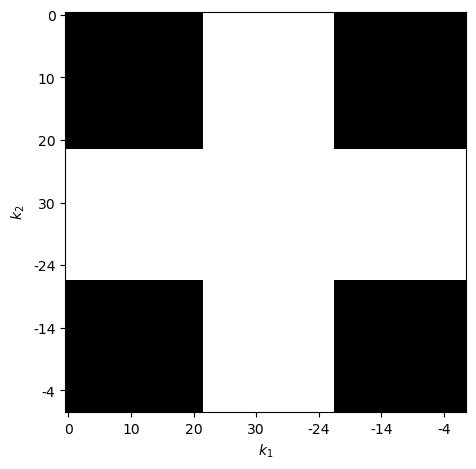

In [8]:
vort_solver_LR.plot_filter()
filter_LR = vort_solver_LR.get_filter()

We work with an input YAML file to load simulation settings:

In [9]:
# get simulation settings
input_file = open("./inputs/input.yml", "r")

In [10]:
input_dict = yaml.safe_load(input_file)
sim_settings = input_dict['sim_settings']
for key in sim_settings.keys():
    vars()[key] = sim_settings[key]
    print("Setting %s to %s" % (key, sim_settings[key]))

Setting SIM_ID to tutorial
Setting STATE_STORE to False
Setting RESTART to True
Setting STORE_DATA to False
Setting STORE_PATH to ~/
Setting PLOT to True
Setting COMPUTE_REF to True
Setting EDDY_FORCING_TYPE to exact


Below we determine when to start the simulation (`T=0` unless `RESTART=True`), and how long to simulate for. Here, `RESTART=True` and we load the `HR` and `LR` state at 365 days from the `restart folder`;

In [11]:
# amount of non-dimensionalized time that corresponds to 1 simulated day (DAY = approx 2 * pi)
DAY = vort_solver_LR.day
# start time
T = 365 * DAY
# end time
T_END = T + 100 * DAY
# number of time steps between T and T_END
n_steps = np.ceil((T_END - T) / DT_LR).astype('int')

If `PLOT = True`, plot the solution to `fig` while running the simulation;

In [12]:
# plot the solution while running
if PLOT: 
    fig = plt.Figure(figsize=[10, 10])

The `draw` subroutine that plots the simulation results;

In [13]:
def draw():
    """
    Draws solution to screen while running the simulation.

    Returns
    -------
    None.

    """
    fig.clf()
    display.clear_output(wait=True) # required to make plot update work in Jupyter notebook

    # contourplot Q1
    ax1 = fig.add_subplot(221, title=r'')
    try:
        ax1.contourf(Q1, 50)
    except NameError:
        pass

    # contourplot Q2
    ax2 = fig.add_subplot(222)
    ax2.contourf(Q2, 50)

    # plot Q_HR and Q_LR
    ax3 = fig.add_subplot(223)
    ax3_2 = ax3.twinx()

    try:
        Q_HR = np.array(campaign.accum_data['Q_HR'])  
        ax3.plot(Q_HR[:, 0], '.', label='HR', color='dodgerblue')
        ax3_2.plot(Q_HR[:, 1], '.', color='dodgerblue')
    except KeyError:
        pass
    
    Q_LR = np.array(campaign.accum_data['Q_LR'])
    ax3.plot(Q_LR[:, 0], label='LR', color='salmon')
    ax3_2.plot(Q_LR[:, 1], color='salmon')

    # plot the sgs term
    ax4 = fig.add_subplot(224, title='SGS term')
    ax4.contourf(sgs, 50)

    display.display(fig) # required to make plot update work in Jupyter notebook


Determine the rate at which to store / plot the solution, expressed in number of time steps

In [14]:
plot_frame_rate = np.floor(DAY / DT_LR).astype('int')
store_frame_rate = np.floor(0.25 * DAY / DT_LR).astype('int')

If `RESTART=True` load a previous state from a file in the `./restart` directory. 

If `RESTART = False`, use the initial condition subroutine from `Vorticity_2D`.

In [15]:
if RESTART:
    # load the HR state from a HDF5 file
    IC_HR = campaign.load_hdf5_data(file_path=
                                    './restart/state_HR_t%d_N%d.hdf5' % (T / DAY, DT_MULTIPLIER))
    # HR vorticity at HR stencil k
    w_hat_k_HR = IC_HR['w_hat_k_HR']
    # HR vorticity at HR stencil k-1
    w_hat_km1_HR = IC_HR['w_hat_km1_HR']
    # HR Jacobian at HR stencil n-1
    VgradW_hat_km1_HR = IC_HR['VgradW_hat_km1_HR']
    # HR vorticity at LR stencil n
    w_hat_n_HR = IC_HR['w_hat_n_HR']
    # HR vorticity at LR stencil n - 1
    w_hat_nm1_HR = IC_HR['w_hat_nm1_HR']

    # load the LR state from a HDF5 file
    IC_LR = campaign.load_hdf5_data(file_path=
                                    './restart/state_LR_t%d_N%d.hdf5' % (T / DAY, DT_MULTIPLIER))
    w_hat_n_LR = IC_LR['w_hat_n_LR']
    w_hat_nm1_LR = IC_LR['w_hat_nm1_LR']
    VgradW_hat_nm1_LR = IC_LR['VgradW_hat_nm1_LR']
else:
    # compute the HR initial condition stencil vorticity at HR step k and k-1
    # and Jacobian at k-1
    w_hat_k_HR, w_hat_km1_HR, VgradW_hat_km1_HR = vort_solver_HR.initial_cond()
    # the corresponding HR values at the times of the LR stencil
    w_hat_n_HR = w_hat_k_HR
    w_hat_nm1_HR = w_hat_km1_HR
    # compute the LR initial condition stencil vorticity at LR step n and n-1
    # and Jacobian at n-1
    w_hat_n_LR, w_hat_nm1_LR, VgradW_hat_nm1_LR = vort_solver_LR.initial_cond()

Loaded VgradW_hat_km1_HR
Loaded w_hat_k_HR
Loaded w_hat_km1_HR
Loaded w_hat_n_HR
Loaded w_hat_nm1_HR
Loaded VgradW_hat_nm1_LR
Loaded w_hat_n_LR
Loaded w_hat_nm1_LR
Loaded w_hat_np1_LR


In [16]:
def draw():
    """
    Draws solution to screen while running the simulation.

    Returns
    -------
    None.

    """
    fig.clf()
    display.clear_output(wait=True) # required to make plot update work in Jupyter notebook

    # contourplot Q1
    ax1 = fig.add_subplot(221, title=r'$\omega$', xticks=[], yticks=[])
    try:
        ax1.contourf(Q1, 50)
    except NameError:
        pass

    # contourplot Q2
    ax2 = fig.add_subplot(222, title=r'$\omega^{\mathcal{R}}$', xticks=[], yticks=[])
    ax2.contourf(Q2, 50)

    # plot Q_HR and Q_LR
    ax3 = fig.add_subplot(223, title=r'QoI', ylabel=r'$E$')
    ax3_2 = ax3.twinx()
    ax3_2.set_ylabel(r'Z')
    
    try:
        Q_HR = np.array(campaign.accum_data['Q_HR'])  
        ax3.plot(Q_HR[:, 0], '.', label='HR', color='dodgerblue')
        ax3_2.plot(Q_HR[:, 1], '.', color='salmon')
    except KeyError:
        pass
    
    Q_LR = np.array(campaign.accum_data['Q_LR'])
    ax3.plot(Q_LR[:, 0], label='LR', color='dodgerblue')
    ax3_2.plot(Q_LR[:, 1], color='salmon')
    ax3.legend()

    # plot the sgs term
    ax4 = fig.add_subplot(224, title='SGS term', xticks=[], yticks=[])
    ax4.contourf(sgs, 50)

    display.display(fig) # required to make plot update work in Jupyter notebook
    plt.tight_layout()

#### Defining Quantities of Interest

As mentioned, our quantities of interest are $E$, and $Z$. This is read from the input file.



In [17]:
# the number of QoI to track
N_Q = input_dict['N_Q']
print("Tracking %d QoI" % (N_Q,))

# get information on the Quantities of Interest
QoI = {}
for i in range(N_Q):
    Q_key = "Q%d" % (i + 1)   #Q1, Q2 etc
    QoI[Q_key] = input_dict[Q_key]
    print(QoI[Q_key])

Tracking 2 QoI
{'name': 'E', 'V_i': '-psi_hat_n_LR'}
{'name': 'Z', 'V_i': 'w_hat_n_LR'}


Below we find the subroutine to compute $E$ and $Z$, along with a subroutine to approximate the associated inner product $\left(\cdot, \cdot\right)$;


In [18]:
def quad(a_hat, b_hat):
    """
    Perform quadrature using Fourier coefficients to approximate the inner product (a, b) / (2*pi)**2 2

    Parameters
    ----------
    a_hat : array (complex), shape (N, N)
        The fourier coefficients of a(x, y).
    b_hat : array (complex), shape (N, N)
        The fourier coefficients of b(x, y).

    Returns
    -------
    float
        The innner product (a, b) / (2*pi)* ** 2.

    """
    N = a_hat.shape[0]
    return np.dot(a_hat.flatten(), np.conjugate(b_hat.flatten())).real / N ** 4

In [19]:
def qoi_func(name, w_hat_n, _filter, **kwargs):
    """
    Function which computes the spatially integrated quantities of interest.

    Parameters
    ----------
    name : string
        Name of the QoI
    w_hat_n : array (complex), shape (N, N)
        Vorticity Fourier coefficients.
    _filter : array, shape (N, N)
        The spectral filter used for calculating the QoI
    **kwargs : array (complex)
        Stream Function Fourier coefficients, passed as a keyword argument.

    Returns
    -------
    qoi : array (real)
        The spatially-integrated QoI

    """

    N = w_hat_n.shape[0]

    # compute energy
    if name == "E":
        psi_hat_n = kwargs['psi_hat']
        qoi = -0.5 * quad(_filter * psi_hat_n, w_hat_n)
    # compute enstrophy
    elif name == "Z":
        qoi = 0.5 * quad(_filter * w_hat_n, w_hat_n)

    return qoi

### Create a reduced surrogate object

This will create a reduced sgs object. Note that it is a limited implementation. It will work for 2D spectral solvers.

In [20]:
# create a reduced SGS surrogate object
surrogate = es.methods.Reduced_Surrogate(N_Q, N_LR)

Creating Reduced Surrogate Object


### Running the simulation

There is an input file `./inputs/input.yml`. To run a simulation with $\overline{r}$ set the flag `EDDY_FORCING_TYPE` to `"exact"`. To overwrite $\overline{r}$ with $\underline{r}$, set `EDDY_FORCING_TYPE = "reduced"`. The solution is plotted to screen. You should note little difference in the evolution of $E$ and $Z$, yet a large difference in the appearance of the 2 SGS terms.

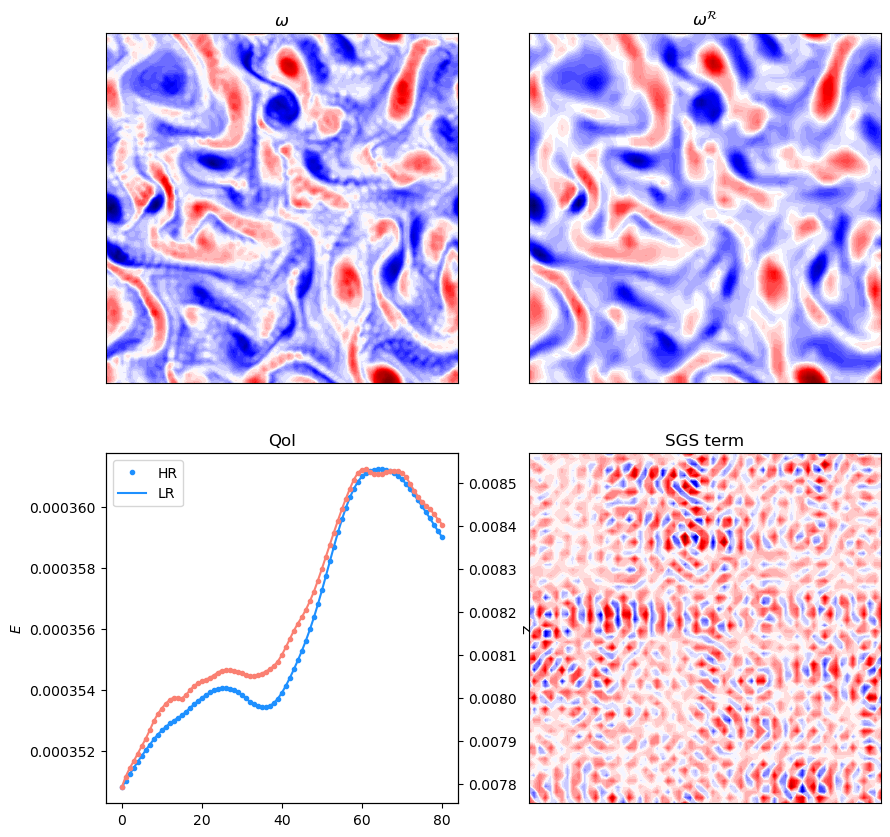

 21%|█████████████████████████████████████████████████                                                                                                                                                                                             | 12984/63003 [01:28<03:32, 235.83it/s]

In [ ]:
# time loop
for n in tqdm(range(n_steps)):

    if COMPUTE_REF:
        # integrate the HR solver over DT_MULTIPLIER HR time steps
        for i in range(DT_MULTIPLIER):
            w_hat_kp1_HR, VgradW_hat_k_HR = vort_solver_HR.step(w_hat_k_HR, w_hat_km1_HR,
                                                                VgradW_hat_km1_HR)
            # update HR vars
            w_hat_km1_HR = np.copy(w_hat_k_HR)
            w_hat_k_HR = np.copy(w_hat_kp1_HR)
            VgradW_hat_km1_HR = np.copy(VgradW_hat_k_HR)

        # the HR vorticity at time t_n = n * DT_LR
        w_hat_np1_HR = w_hat_kp1_HR

        # exact sgs term
        sgs_hat_exact = filter_LR * (vort_solver_HR.down_scale(VgradW_hat_km1_HR, N_LR) - VgradW_hat_nm1_LR)

        # compute the HR stream function
        psi_hat_n_HR = vort_solver_HR.compute_stream_function(w_hat_n_HR)

        # compute the QoI using the HR state
        Q_HR = np.zeros(N_Q)
        for q in range(N_Q):
            Q_key = "Q%d" % (q + 1,)
            Q_HR[q] = qoi_func(QoI[Q_key]['name'],
                               vort_solver_HR.down_scale(w_hat_n_HR, N_LR),
                               filter_LR,
                               psi_hat = vort_solver_HR.down_scale(psi_hat_n_HR, N_LR))

    # compute the LR stream function
    psi_hat_n_LR = vort_solver_LR.compute_stream_function(w_hat_n_LR)

    # compute the QoI using the LR state
    Q_LR = np.zeros(N_Q)
    for q in range(N_Q):
        Q_key = "Q%d" % (q + 1,)
        Q_LR[q] = qoi_func(QoI[Q_key]['name'],
                           w_hat_n_LR,
                           filter_LR,
                           psi_hat = psi_hat_n_LR)

    # overwrite reduced sgs term with exact sgs term if True
    if EDDY_FORCING_TYPE == "exact": 
        sgs_hat = sgs_hat_exact
    elif EDDY_FORCING_TYPE == 'reduced':
        # The QoI basis functions V_i = \partial q_i / \partial \omega
        V_i = []
        for q in range(N_Q):
            Q_key = "Q%d" % (q + 1,)
            V_i.append(filter_LR * eval(QoI[Q_key]['V_i']))
        
        # compute the reduced subgrid-scale term
        dQ = Q_HR - Q_LR
        reduced_dict = surrogate.train(V_i, dQ)
        sgs_hat = reduced_dict['sgs_hat']

    # integrate the LR solver with sgs term
    w_hat_np1_LR, VgradW_hat_n_LR = vort_solver_LR.step(w_hat_n_LR, w_hat_nm1_LR,
                                                        VgradW_hat_nm1_LR,
                                                        sgs_hat=sgs_hat)
    # update LR vars
    w_hat_nm1_LR = w_hat_n_LR
    w_hat_n_LR = w_hat_np1_LR
    VgradW_hat_nm1_LR = VgradW_hat_n_LR

    if COMPUTE_REF:
        # update HR vars on LR time stencil
        w_hat_nm1_HR = w_hat_n_HR
        w_hat_n_HR = w_hat_np1_HR

    T += DT_LR
    
    # accumulate QoI data inside the EasySurrogate campaign
    if np.mod(n, store_frame_rate) == 0:

        campaign.accumulate_data({'Q_LR': Q_LR})
        
        if COMPUTE_REF: campaign.accumulate_data({'Q_HR': Q_HR})

    # plot solution while running
    if np.mod(n, plot_frame_rate) == 0 and PLOT:

        if COMPUTE_REF: 
            Q1 = np.fft.ifft2(w_hat_np1_HR).real

        Q2 = np.fft.ifft2(w_hat_np1_LR).real
        sgs = np.fft.ifft2(sgs_hat).real
        draw()